In [88]:
import jax
jax.config.update("jax_enable_x64", True)

import os
import sys

sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/gp_fusion')

from modules.data_handling import load_data  # Same as using Dataset but X and Y have std dv = 1 column-wise
from modules.fusion_methods import compute_neg_log_like

from uci_datasets import Dataset
import matplotlib.pyplot as plt

## Define LOO loss (it's the minus LOO log-probability of training data)

In [89]:
# import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax.scipy.linalg import cho_factor, cho_solve
import optax



# RBF Kernel function with length_scale as a vector
def rbf_kernel(x1, x2, length_scale, variance):
    sqdist = jnp.sum(((x1 - x2) / length_scale) ** 2)
    return variance * jnp.exp(-0.5 * sqdist)

# Efficient kernel matrix computation using vmap
def kernel_matrix(X1, X2, length_scale, variance, noise, include_noise=True):
    pairwise_dists = jnp.sum(
        ((X1[:, None, :] - X2[None, :, :]) / jnp.broadcast_to(length_scale, X1[:, None, :].shape)) ** 2, 
        axis=-1)
    K = variance * jnp.exp(-0.5 * pairwise_dists)
    if include_noise:
        K += (noise + 1e-6) * jnp.eye(X1.shape[0]) 
    return K

# Compute alpha and diagonal elements of the inverse of K using Cholesky
def compute_alpha_and_diag_inv_K(K_chol, y):
    alpha = cho_solve((K_chol, True), y)
    
    compute_diag = jax.vmap(lambda A,b,i: cho_solve((A,True),b)[i], in_axes=(None,0,0))
    diag_inv_K = compute_diag(K_chol,jnp.eye(K_chol.shape[0]), jnp.arange(K_chol.shape[0])) 
    
    return alpha, diag_inv_K

# LOO-CV objective function
def loo_cv_objective(params, X, y):
    log_length_scale, log_variance, log_noise = params[:-2], params[-2], params[-1]
    length_scale, variance, noise = jnp.exp(log_length_scale), jnp.exp(log_variance), jnp.exp(log_noise)
    
    K = kernel_matrix(X, X, length_scale, variance, noise)
    K_chol = cho_factor(K, lower=True)[0]
    
    # Compute alpha and diagonal of K_inv using Cholesky factorization
    alpha, diag_inv_K = compute_alpha_and_diag_inv_K(K_chol, y)
    
    # LOO predictive mean and variance
    loo_means = y - alpha / diag_inv_K
    loo_vars = 1/diag_inv_K
    
    # LOO predictive log-probability
    loo_cv_log_score = -0.5 * jnp.sum(jnp.log(loo_vars.squeeze()) + \
                                      (y.squeeze() - loo_means.squeeze())**2 / loo_vars.squeeze())
    return -loo_cv_log_score, loo_means, loo_vars

# JIT compile the objective function for faster optimization
# loo_cv_objective_jit = jit(loo_cv_objective)

# JIT compile the objective function for faster optimization
loo_cv_objective_jit = jit(lambda params, X, y: loo_cv_objective(params, X, y)[0])



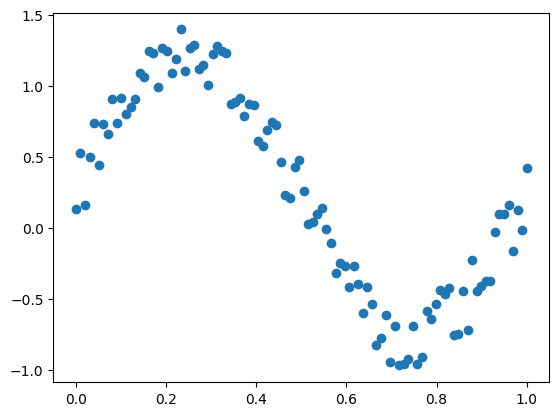

In [91]:
import numpy as np
X_train = np.linspace(0,1,100).reshape(-1,1)
y_train = np.sin(2*np.pi*X_train).squeeze()
y_train = y_train + + 0.5*np.random.rand(len(y_train))
plt.scatter(X_train,y_train)

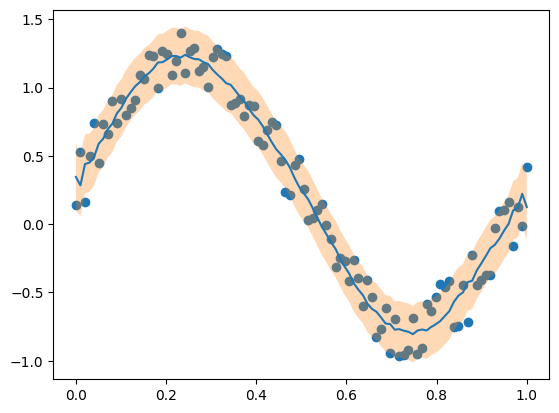

In [92]:
# %%script true
# plotting the loo_means and loo_vars
init_params = jnp.log(jnp.array([0.2,1.0,0.01]))
_,loo_means,loo_vars = loo_cv_objective(init_params,X_train,y_train)

plt.scatter(X_train,y_train)
plt.plot(X_train, loo_means)
plt.fill_between(X_train.squeeze(), loo_means + 2*jnp.sqrt(loo_vars),
                 loo_means - 2*jnp.sqrt(loo_vars),alpha=0.3)


In [96]:
# Initial parameters: log(length_scale), log(variance), log(noise)
init_params = jnp.log(jnp.concatenate((0.5*jnp.ones(X_train.shape[1]),
                                       jnp.array([0.1]), 
                                       jnp.array([0.5]))
                                       ) 
                                       )  # Adjust length to match X_train.shape[1] + 2

# Define the optimizer
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(init_params)

# Define the update step
@jit
def update(params, opt_state, X, y):
    loss, grads = value_and_grad(loo_cv_objective_jit)(params, X, y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

# Training loop
params = init_params
num_steps = 100
for step in range(num_steps):
    loss, params, opt_state = update(params, opt_state, X_train, y_train)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss}")
        # print(f"Lenghtscale: {jnp.round(jnp.exp(params[:-2]),decimals=0)}, \
        #       Variance:  {jnp.round(jnp.exp(params[-2]),decimals=0)}, \
        #         Noise: {jnp.round(jnp.exp(params[-1]),decimals=0)}")

# Get the optimized parameters
optimized_params = jnp.exp(params)
length_scale, variance, noise = optimized_params[:-2], optimized_params[-2], optimized_params[-1]
print("Optimized Length Scale:", length_scale)
print("Optimized Variance:", variance)
print("Optimized Noise:", noise)


Step 0, Loss: -16.487346540493043
Optimized Length Scale: [0.24221567]
Optimized Variance: 0.2283998714217621
Optimized Noise: 0.17536549365047593


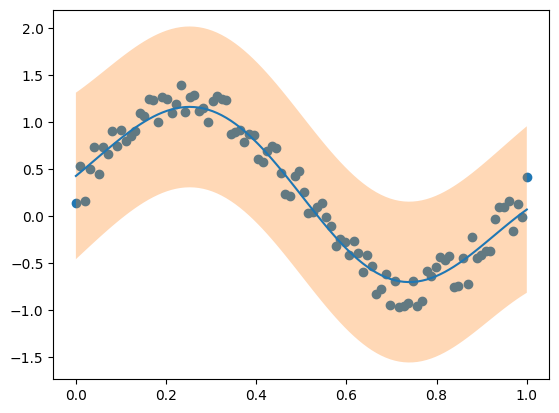

In [97]:
# Function to make predictions with the optimized GP
def predict_gp(X_train, y_train, X_test, length_scale, variance, noise):
    # Compute the kernel matrices
    K = kernel_matrix(X_train, X_train, length_scale, variance, noise)
    K_s = kernel_matrix(X_test, X_train, length_scale, variance, noise, include_noise=False)
    K_ss = kernel_matrix(X_test, X_test, length_scale, variance, noise)

    # Cholesky factorization of K
    K_chol = cho_factor(K, lower=True)[0]
    
    # Compute the mean and variance of the predictive distribution
    alpha = cho_solve((K_chol, True), y_train)
    v = cho_solve((K_chol, True), K_s.T)
    
    mu_s = K_s @ alpha
    cov_s = K_ss - K_s @ v
    
    return mu_s, jnp.diag(cov_s)

X_test = jnp.linspace(0,1,100).reshape(-1,1)
y_test = jnp.sin(2*jnp.pi*X_test).squeeze()
y_test = y_test + + 0.5*np.random.rand(len(y_test))

mu_tr, var_tr = predict_gp(X_train, y_train, X_train, length_scale, variance, noise)
mu_tst, var_tst = predict_gp(X_train, y_train, X_test, length_scale, variance, noise)

plt.scatter(X_train, y_train)
plt.plot(X_test,mu_tst)
plt.fill_between(X_test.squeeze(),mu_tst + 2*jnp.sqrt(var_tst),
                 mu_tst - 2*jnp.sqrt(var_tst), alpha=0.3)

In [98]:
compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train),\
    compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test)

(array([0.13233632]), array([0.12101072]))

## Fit LOO-GP to UCI datasets

In [83]:
dataset_names = ["autos", 'housing','stock','sml',
                 'elevators','breastcancer','forest','gas',
                 ]


dataset_name = dataset_names[1]
full_dataset = Dataset(dataset_name)
N,DIM = full_dataset.x.shape


# load_data uses the normalized dataset, i.e., full_dataset.x and full_dataset.y have unit variance
split = 0
X_train,y_train,X_test,y_test,_ = load_data(dataset_name,split)

housing dataset, N=506, d=13


In [85]:
# Initial parameters: log(length_scale), log(variance), log(noise)
init_params = jnp.log(jnp.concatenate((0.5*jnp.ones(X_train.shape[1]),
                                       jnp.array([1.0]), 
                                       jnp.array([0.5]))
                                       ) 
                                       )  # Adjust length to match X_train.shape[1] + 2
init_params = jnp.zeros((X_train.shape[1] + 2))

# Define the optimizer
optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(init_params)

# Define the update step
@jit
def update(params, opt_state, X, y):
    loss, grads = value_and_grad(loo_cv_objective_jit)(params, X, y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

# Training loop
params = init_params
num_steps = 100
for step in range(num_steps):
    loss, params, opt_state = update(params, opt_state, X_train, y_train)
    if step % 100 == 0 or step == num_steps-1:
        print(f"Step {step}, Loss: {loss}")
        # print(f"Lenghtscale: {jnp.round(jnp.exp(params[:-2]),decimals=0)}, \
        #       Variance:  {jnp.round(jnp.exp(params[-2]),decimals=0)}, \
        #         Noise: {jnp.round(jnp.exp(params[-1]),decimals=0)}")

# Get the optimized parameters
optimized_params = jnp.exp(params)
length_scale, variance, noise = optimized_params[:-2], optimized_params[-2], optimized_params[-1]
print("Optimized Length Scale:", length_scale)
print("Optimized Variance:", variance)
print("Optimized Noise:", noise)


Step 0, Loss: 129.97715592111007
Step 99, Loss: -393.3660998883898
Optimized Length Scale: [ 7.02224644  4.38548679 12.75413565 23.05978026  0.40088815  2.56449783
  3.04253701  4.04711942  1.43949589  0.97051482  4.64550481  2.9157515
  0.79461437]
Optimized Variance: 0.7412571562637517
Optimized Noise: 0.029399012034262848


In [86]:
# compute nlpd on training and test data
mu_tr, var_tr = predict_gp(X_train, y_train, X_train, length_scale, variance, noise)
mu_tst, var_tst = predict_gp(X_train, y_train, X_test, length_scale, variance, noise)

In [87]:
print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))

NLPD Train:  [-0.46869797]
NLPD Test:  [-0.00430868]
RMSE Train:  0.12240318099678597
RMSE Test:  0.2507016712984305


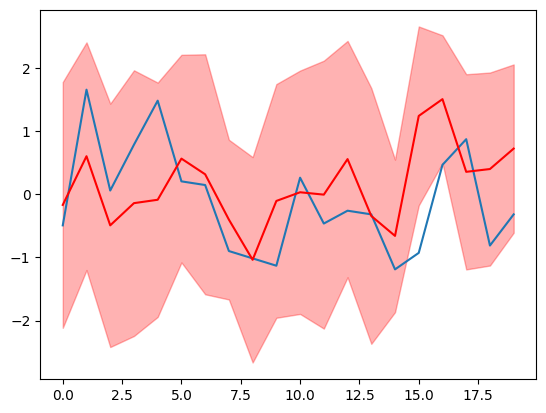

In [80]:
upper, lower = mu_tst + 2*jnp.sqrt(var_tst), mu_tst - 2*jnp.sqrt(var_tst)
plt.plot(y_test)
plt.plot(mu_tst,color="red")
plt.fill_between(np.arange(len(y_test)), upper, lower,color="red",alpha=0.3)


NLPD Train:  [0.89694613]
NLPD Test:  [1.34586164]
RMSE Train:  0.3395282716666138
RMSE Test:  0.8201043235297627


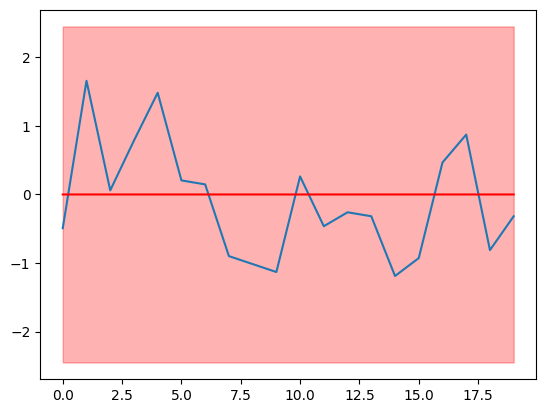

In [81]:
# if we were to use the initial values of the hyperparameters

# compute nlpd on training and test data
mu_tr, var_tr = predict_gp(X_train, y_train, X_train, jnp.exp(init_params[:-2]), jnp.exp(init_params[-2]), jnp.exp(init_params[-1]))
mu_tst, var_tst = predict_gp(X_train, y_train, X_test, jnp.exp(init_params[:-2]), jnp.exp(init_params[-2]), jnp.exp(init_params[-1]))

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))

upper, lower = mu_tst + 2*jnp.sqrt(var_tst), mu_tst - 2*jnp.sqrt(var_tst)
plt.plot(y_test)
plt.plot(mu_tst,color="red")
plt.fill_between(np.arange(len(y_test)), upper, lower,color="red",alpha=0.3)